In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

# Set font before plotting
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/data_with_press_and_weather.csv', low_memory=False)

# Drop rows with excessive missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

# Clean and filter '강번'
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])
df = df[df['강번'].between(9000, 500000000)]


# For double checking
df.to_csv('For_my_use_1.csv', index=False)


chin_variables = [col for col in df.columns if '친' in col and '친단\u3000손' not in col and '친단\u3000자' not in col]
son_variables = [col for col in df.columns if '손' in col]
ja_variables = [col for col in df.columns if '자' in col and '자동차' not in col and '부자재' not in col]

df['chin_total'] = df[chin_variables].sum(axis=1)
df['son_total'] = df[son_variables].sum(axis=1)
df['ja_total'] = df[ja_variables].sum(axis=1)

if 'chin_total' in df.columns:
    target_value = len(df)
    df = df[df['chin_total'] <= 40000]
    removed_target_value = target_value - len(df)
    print(f"Removed {removed_target_value} rows where 'chin_total' > 40000.")
else:
    print(f"Warning: '장입량t' column not found.")

Rows with more than half NaN dropped. Remaining rows: 2811
Removed 1 rows where 'chin_total' > 40000.


In [2]:
# Define drop condition (can be adjusted)
df['chin_drop_flag'] = np.where(df['chin_total'] <= 28000, 1, 0)
print(df['chin_drop_flag'].value_counts())
df['temp'] = df['A부스러기\u3000친'] + df['B부스러기\u3000친']
chin_variables = chin_variables + ['temp']

chin_drop_flag
0    2459
1     345
Name: count, dtype: int64


In [3]:
# Feature matrix and target
X = df[chin_variables]
y = df['chin_drop_flag']

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:23:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


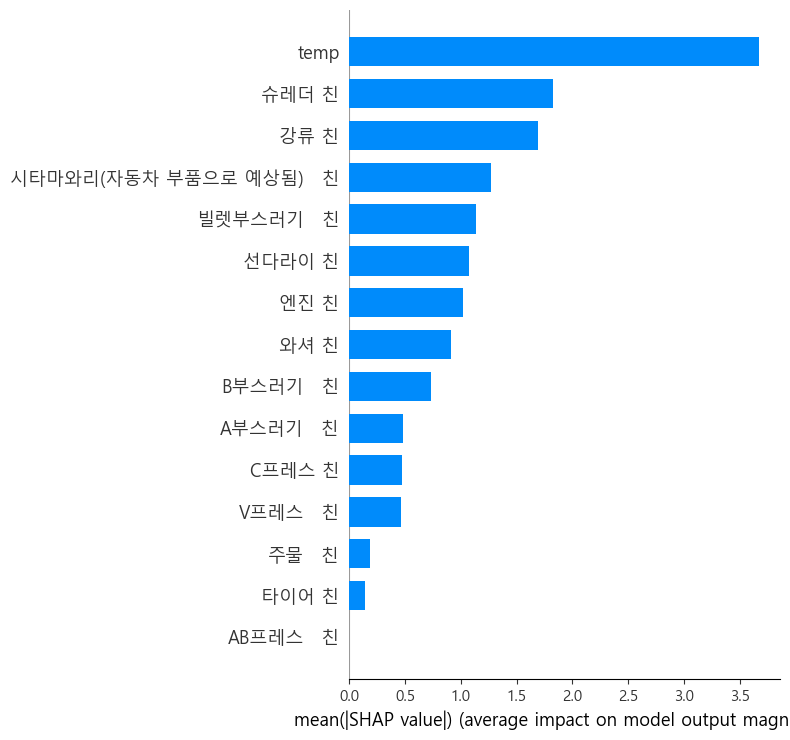

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)